General imports

In [144]:
import pandas as pd
import matplotlib.pyplot as plt

Reading dataset

In [145]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv', parse_dates = ["dt"])

Quick view to the data

In [146]:
df.head()
df.dropna()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
5,1744-04-01,1.530,4.680,Åland
6,1744-05-01,6.702,1.789,Åland
7,1744-06-01,11.609,1.577,Åland
8,1744-07-01,15.342,1.410,Åland
...,...,...,...,...
577456,2013-04-01,21.142,0.495,Zimbabwe
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe


In [147]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df)
# profile

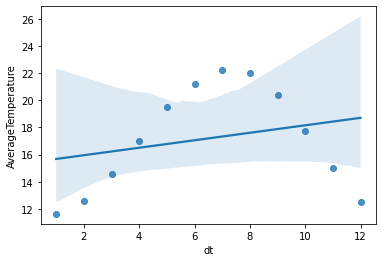

In [148]:
df['dt'] = pd.to_datetime(df['dt'])
# monthlyDF = df.groupby(df['dt'].dt.strftime('%m'))['AverageTemperature'].mean().sort_values().reset_index(name='AverageTemperature')
# monthlyDF
monthlyDF = monthlyDF.sort_values('dt')
monthlyDF.rename(columns={0 : 'AverageTemperature'}, inplace=True)
monthlyDF['AverageTemperature'] = monthlyDF['AverageTemperature'].apply(lambda x: float(x))
monthlyDF['dt'] = monthlyDF['dt'].apply(lambda x: float(x))
sns.regplot(x=monthlyDF["dt"], y=monthlyDF["AverageTemperature"])
plt.show()

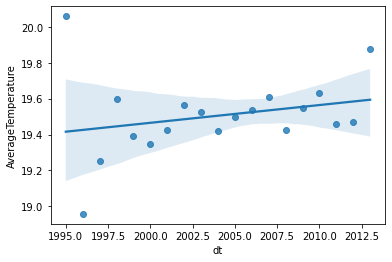

In [151]:
df['dt'] = pd.to_datetime(df['dt'])
last20YearsDF = df[(df['dt'] > '1995-06-01') & (df['dt'] < '2014-01-01')]
last20YearsDF = (last20YearsDF.groupby(df['dt'].dt.strftime('%Y'))['AverageTemperature'].mean().sort_values().reset_index(name='AverageTemperature'))
last20YearsDF = last20YearsDF.sort_values('dt')
last20YearsDF.rename(columns={0 : 'AverageTemperature'}, inplace=True)
last20YearsDF['AverageTemperature'] = last20YearsDF['AverageTemperature'].apply(lambda x: float(x))
last20YearsDF['dt'] = last20YearsDF['dt'].apply(lambda x: float(x))
sns.regplot(x=last20YearsDF["dt"], y=last20YearsDF["AverageTemperature"])
plt.show()

<AxesSubplot:>

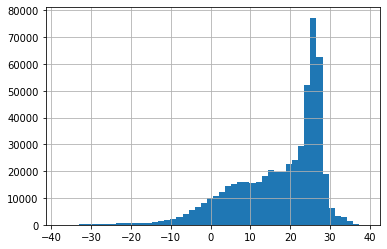

In [ ]:
#2a.

df['AverageTemperature'].hist(bins=50)

<AxesSubplot:xlabel='dt', ylabel='AverageTemperature'>

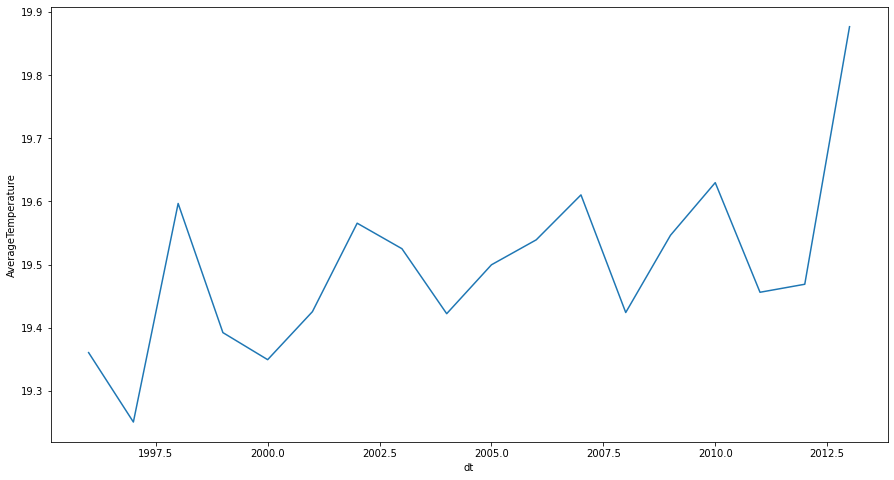

In [ ]:
df['dt'] = pd.to_datetime(df['dt'])
last20YearsDF = df[(df['dt'] > '1996-01-01')]
last20YearsDF = (last20YearsDF.groupby(df['dt'].dt.strftime('%Y'))['AverageTemperature'].mean().sort_values().reset_index(name='AverageTemperature'))
last20YearsDF = last20YearsDF.sort_values('dt')
last20YearsDF.rename(columns={0 : 'AverageTemperature'}, inplace=True)
last20YearsDF['AverageTemperature'] = last20YearsDF['AverageTemperature'].apply(lambda x: float(x))
last20YearsDF['dt'] = last20YearsDF['dt'].apply(lambda x: float(x))
plt.figure(figsize = (15,8))
sns.lineplot(x=last20YearsDF["dt"], y=last20YearsDF["AverageTemperature"])

# plt.show()